# GRID LoL Data Exploration (Advanced)

This notebook explores your GRID LoL dataset from `data_fetching/`. It builds player/team behavior features, infers roles, and uncovers patterns via clustering and similarity analysis.

In [2]:
from pathlib import Path
import json
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

try:
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics.pairwise import cosine_similarity
    _HAS_SK = True
except Exception:
    _HAS_SK = False

try:
    import networkx as nx
    _HAS_NX = True
except Exception:
    _HAS_NX = False

try:
    import ipywidgets as widgets
    from IPython.display import display
    _HAS_W = True
except Exception:
    _HAS_W = False

DATA_DIR = Path("../data_fetching")
SERIES_PATH = DATA_DIR / "series.jsonl"
STATE_PATH = DATA_DIR / "series_state.jsonl"
ROLE_MAP_PATH = Path("../scouting/role_map.json")

assert SERIES_PATH.exists(), f"Missing {SERIES_PATH}"
assert STATE_PATH.exists(), f"Missing {STATE_PATH}"
assert ROLE_MAP_PATH.exists(), f"Missing {ROLE_MAP_PATH}"

print("Series lines:", sum(1 for _ in SERIES_PATH.open()))
print("SeriesState lines:", sum(1 for _ in STATE_PATH.open()))

Series lines: 1632
SeriesState lines: 665


In [3]:
# Helpers

def load_jsonl(path: Path):
    rows = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                rows.append(json.loads(line))
            except Exception:
                continue
    return rows


def normalize_key(s: str) -> str:
    if not s:
        return ""
    return "".join(ch for ch in s.lower() if ch.isalnum())


def to_bool(x):
    if isinstance(x, bool):
        return x
    if isinstance(x, str):
        if x.lower() in ("true","t","1","yes","y"): return True
        if x.lower() in ("false","f","0","no","n"): return False
    return None


def to_num(x):
    try:
        if x is None:
            return None
        return float(x)
    except Exception:
        return None

role_map_raw = json.loads(ROLE_MAP_PATH.read_text(encoding="utf-8"))
role_map = {normalize_key(k): v for k, v in role_map_raw.items()}

series = load_jsonl(SERIES_PATH)
series_by_id = {str(s.get("id")): s for s in series}

# Build a fallback team_id -> team_name map from series.jsonl
team_name_map = {}
for s in series:
    for t in (s.get("teams") or []):
        base = t.get("baseInfo") or {}
        tid = base.get("id")
        name = base.get("name")
        if tid and name:
            team_name_map[str(tid)] = name

print("team_name_map size:", len(team_name_map))
print("team_name_map sample:", list(team_name_map.items())[:5])

state_rows = load_jsonl(STATE_PATH)
non_null = [r for r in state_rows if r.get("seriesState")]
print("SeriesState with data:", len(non_null))

team_name_map size: 56
team_name_map sample: [('52661', 'Shifters'), ('47380', 'G2 Esports'), ('353', 'SK Gaming'), ('106', 'Rogue'), ('47376', 'Fnatic')]
SeriesState with data: 523


## Flatten data to game/team and player rows

In [4]:
# Flatten to game/team rows and player rows

game_rows = []
player_rows = []

for rec in non_null:
    series_id = str(rec.get("series_id"))
    state = rec.get("seriesState") or {}
    games = state.get("games") or []

    # Series-level metadata (from series.jsonl)
    s_meta = series_by_id.get(series_id, {})
    tournament = s_meta.get("tournament") or {}
    start_time = s_meta.get("startTimeScheduled")

    for g in games:
        seq = g.get("sequenceNumber")
        teams = g.get("teams") or []
        if len(teams) < 2:
            continue

        team_by_id = {str(t.get("id")): t for t in teams if t.get("id") is not None}

        for t in teams:
            team_id = str(t.get("id")) if t.get("id") is not None else None
            if not team_id:
                continue
            opp = None
            for oid, ot in team_by_id.items():
                if oid != team_id:
                    opp = ot
                    break

            team_name = t.get("name") or team_name_map.get(team_id)
            opp_id = str(opp.get("id")) if opp else None
            opp_name = (opp.get("name") if opp else None) or (team_name_map.get(opp_id) if opp_id else None)

            row = {
                "series_id": series_id,
                "game_number": seq,
                "team_id": team_id,
                "team_name": team_name,
                "opponent_id": opp_id,
                "opponent_name": opp_name,
                "won": to_bool(t.get("won")),
                "kills": to_num(t.get("kills")),
                "deaths": to_num(t.get("deaths")),
                "tournament_id": tournament.get("id"),
                "tournament_name": tournament.get("name"),
                "start_time": start_time,
            }
            game_rows.append(row)

            for p in (t.get("players") or []):
                champ = None
                char = p.get("character") or {}
                if isinstance(char, dict):
                    champ = char.get("name")
                role = role_map.get(normalize_key(champ), None) if champ else None

                player_rows.append({
                    "series_id": series_id,
                    "game_number": seq,
                    "team_id": team_id,
                    "team_name": team_name,
                    "opponent_name": opp_name,
                    "won": to_bool(t.get("won")),
                    "player_id": p.get("id"),
                    "player_name": p.get("name"),
                    "champion": champ,
                    "role": role,
                    "kills": to_num(p.get("kills")),
                    "deaths": to_num(p.get("deaths")),
                    "tournament_id": tournament.get("id"),
                    "tournament_name": tournament.get("name"),
                    "start_time": start_time,
                })


games_df = pd.DataFrame(game_rows)
players_df = pd.DataFrame(player_rows)

# Final fallback: fill team_name from team_id mapping
players_df["team_name"] = players_df["team_name"].fillna(players_df["team_id"].map(team_name_map))
games_df["team_name"] = games_df["team_name"].fillna(games_df["team_id"].map(team_name_map))

# Use team_key for grouping if name is still missing
players_df["team_key"] = players_df["team_name"].fillna(players_df["team_id"])
games_df["team_key"] = games_df["team_name"].fillna(games_df["team_id"])

print("games_df:", games_df.shape)
print("players_df:", players_df.shape)

games_df: (1994, 13)
players_df: (10000, 16)


## Role inference (fallback by player history)

In [5]:
role_known = players_df.dropna(subset=["player_name","role"])
player_primary_role = (
    role_known.groupby(["player_name","role"]).size()
    .reset_index(name="picks")
    .sort_values(["player_name","picks"], ascending=[True, False])
    .drop_duplicates("player_name")
    .set_index("player_name")["role"]
)

players_df["role_inferred"] = players_df["role"]
players_df.loc[players_df["role_inferred"].isna(), "role_inferred"] = (
    players_df.loc[players_df["role_inferred"].isna(), "player_name"].map(player_primary_role)
)

print("Role coverage (raw):", players_df["role"].notna().mean())
print("Role coverage (inferred):", players_df["role_inferred"].notna().mean())

Role coverage (raw): 0.6827
Role coverage (inferred): 0.9994


## Team-level tendencies (diversity + aggression)

In [6]:
def entropy(series):
    total = series.sum()
    if total == 0:
        return 0.0
    probs = series / total
    return float(-(probs * np.log2(probs)).sum())

team_champ_counts = (
    players_df.dropna(subset=["champion","team_key"])
    .groupby(["team_key", "champion"]).size().reset_index(name="picks")
)

team_entropy = (
    team_champ_counts
    .groupby("team_key")["picks"].apply(entropy)
    .reset_index(name="champion_entropy")
)

team_aggr = (
    games_df.dropna(subset=["kills","deaths","team_key"])
    .assign(aggression=lambda d: d["kills"]/(d["kills"]+d["deaths"]))
    .groupby("team_key")["aggression"].mean()
    .reset_index()
)

team_stats = team_entropy.merge(team_aggr, on="team_key", how="left")
team_stats = team_stats.sort_values("champion_entropy", ascending=False)
team_stats.head(15)

,team_key,champion_entropy,aggression
14,G2 Esports,5.958631,0.566393
36,T1,5.794613,0.552797
8,DRX,5.757966,0.382743
7,DN SOOPers,5.708881,0.444399
10,Dplus KIA,5.707020,0.557813
40,Team Vitality,5.680322,0.457953
11,FlyQuest,5.679397,0.553540
23,Movistar KOI,5.673410,0.492723
21,KT Rolster,5.670286,0.497848
22,Karmine Corp,5.669632,0.458539


## Role share by team (inferred)

In [7]:
role_counts = (
    players_df.dropna(subset=["role_inferred","team_key"])
    .groupby(["team_key","role_inferred"]).size().reset_index(name="picks")
)
role_pivot = role_counts.pivot(index="team_key", columns="role_inferred", values="picks").fillna(0)
role_pivot["total"] = role_pivot.sum(axis=1)
role_share = role_pivot.div(role_pivot["total"], axis=0).drop(columns=["total"])
role_share.head()

role_inferred,bot,jg,mid,sup,top
team_key,,,,,
100 Thieves,0.217647,0.182353,0.188235,0.194118,0.217647
Anyone's Legend,0.225000,0.218750,0.168750,0.175000,0.212500
BILIBILI GAMING DREAMSMART,0.211268,0.239437,0.176056,0.190141,0.183099
BNK FearX,0.205714,0.214286,0.202857,0.180000,0.197143
BRION,0.216438,0.186301,0.227397,0.186301,0.183562


## Champion pair co-occurrence (team composition patterns)

In [8]:
comp_rows = []
for (series_id, game_number, team_key), grp in players_df.dropna(subset=["champion","team_key"]).groupby(["series_id","game_number","team_key"]):
    champs = sorted(set(grp["champion"].dropna().tolist()))
    for i in range(len(champs)):
        for j in range(i+1, len(champs)):
            comp_rows.append({
                "team_key": team_key,
                "champ_pair": f"{champs[i]} + {champs[j]}"
            })

comp_df = pd.DataFrame(comp_rows)

for team in comp_df["team_key"].value_counts().head(5).index:
    top_pairs = comp_df[comp_df["team_key"] == team]["champ_pair"].value_counts().head(10)
    print("", team)
    display(top_pairs)

 Dplus KIA


champ_pair
Lucian + Nami             13
Kalista + Renata Glasc     9
Rakan + Xayah              8
Taliyah + Vi               7
Aatrox + Rell              7
Aatrox + Lucian            6
Rakan + Vi                 6
Aatrox + Nami              5
Vi + Zeri                  5
Aatrox + Azir              5
Name: count, dtype: int64

 T1


champ_pair
Lucian + Nami         10
K'Sante + Tristana     6
Senna + Tahm Kench     6
Aatrox + Taliyah       6
Senna + Viego          6
Orianna + Rell         5
Corki + Sejuani        5
Aatrox + Nami          5
Aatrox + Orianna       5
Azir + Senna           5
Name: count, dtype: int64

 Hanwha Life Esports


champ_pair
Lucian + Nami        6
Azir + Rell          6
Azir + Varus         6
Rell + Varus         6
Rell + Sejuani       6
Aatrox + Nautilus    5
K'Sante + Rell       5
Aatrox + Sejuani     5
Alistar + Zeri       5
Sejuani + Yone       5
Name: count, dtype: int64

 Gen.G Esports


champ_pair
Corki + Nautilus      7
Corki + K'Sante       7
Corki + Zeri          7
Azir + Nautilus       6
K'Sante + Rell        6
Ezreal + Leona        5
Lucian + Nami         5
K'Sante + Varus       5
Lucian + Milio        5
Aphelios + K'Sante    5
Name: count, dtype: int64

 KT Rolster


champ_pair
Taliyah + Vi          7
K'Sante + Taliyah     7
Azir + K'Sante        6
Lee Sin + Orianna     6
Nautilus + Varus      6
K'Sante + Kalista     5
Orianna + Udyr        5
Azir + Gnar           5
Kalista + Xin Zhao    5
K'Sante + Leona       5
Name: count, dtype: int64

## Clustering: team game archetypes by draft composition

In [9]:
team_game = (
    players_df.dropna(subset=["champion","team_key"])
    .groupby(["series_id","game_number","team_key"]).apply(lambda d: list(d["champion"]))
    .reset_index(name="champions")
)

TOP_N = 80
champ_vocab = players_df["champion"].value_counts().head(TOP_N).index.tolist()
champ_index = {c:i for i,c in enumerate(champ_vocab)}

X = np.zeros((len(team_game), len(champ_vocab)), dtype=np.float32)
for i, champs in enumerate(team_game["champions"]):
    for c in set(champs):
        idx = champ_index.get(c)
        if idx is not None:
            X[i, idx] = 1.0

print("Team-game rows:", len(team_game))
print("Vector shape:", X.shape)

Team-game rows: 1976
Vector shape: (1976, 80)


/var/folders/m7/5g6r4bs10r13n18xl624y6fm0000gn/T/ipykernel_6556/3472150643.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby(["series_id","game_number","team_key"]).apply(lambda d: list(d["champion"]))


In [10]:
if _HAS_SK and len(team_game) >= 10:
    ks = [2,3,4]
    best_k = 2
    best_score = -1
    for k in ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = km.fit_predict(X)
        if len(set(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_k = k
    km = KMeans(n_clusters=best_k, n_init=10, random_state=42)
    team_game["cluster"] = km.fit_predict(X)
    print("Chosen k:", best_k, "silhouette:", round(best_score,3))
else:
    print("sklearn not available or insufficient data.")

Chosen k: 4 silhouette: 0.051


## Per-team “signature cluster” cards

In [11]:
if "cluster" in team_game:
    tg = team_game.merge(
        games_df[["series_id","game_number","team_key","won"]],
        on=["series_id","game_number","team_key"],
        how="left"
    )

    cards = []
    for team, grp in tg.groupby("team_key"):
        c_counts = grp["cluster"].value_counts()
        primary_cluster = int(c_counts.idxmax())
        primary_share = float(c_counts.max() / c_counts.sum())

        c_grp = grp[grp["cluster"] == primary_cluster]
        wins = (c_grp["won"] == True).sum()
        games = c_grp["won"].notna().sum()
        winrate = wins / games if games else None

        champs = pd.Series([c for lst in c_grp["champions"] for c in lst])
        top_champs = champs.value_counts().head(6).index.tolist()

        cards.append({
            "team": team,
            "primary_cluster": primary_cluster,
            "share": round(primary_share,3),
            "winrate": round(winrate,3) if winrate is not None else None,
            "top_champs": top_champs,
        })

    cards_df = pd.DataFrame(cards).sort_values(["share","winrate"], ascending=False)
    display(cards_df.head(15))
else:
    print("Clusters not available.")

,team,primary_cluster,share,winrate,top_champs
6,Cloud9 Kia,2,0.781,0.600,"[Renekton, Nautilus, Senna, Lucian, Zeri, Nami]"
11,FlyQuest,2,0.750,0.667,"[Karma, Varus, Kalista, Nautilus, Renekton, Se..."
22,Karmine Corp,2,0.735,0.440,"[Rakan, Azir, Vi, Nautilus, Zeri, Taliyah]"
10,Dplus KIA,2,0.654,0.566,"[Vi, Gnar, Renata Glasc, Zeri, Aatrox, Sejuani]"
15,GIANTX,2,0.644,0.310,"[Maokai, Alistar, Sejuani, Rakan, Varus, Ezreal]"
0,100 Thieves,2,0.618,0.524,"[Nautilus, Taliyah, Aatrox, Senna, Jax, Kai'Sa]"
23,Movistar KOI,2,0.607,0.514,"[Azir, Rakan, Senna, Nautilus, Braum, Xayah]"
33,Shifters,2,0.590,0.556,"[Azir, Nautilus, Xin Zhao, Rakan, Varus, Ashe]"
21,KT Rolster,2,0.562,0.488,"[Vi, Orianna, Gnar, Udyr, Taliyah, Sejuani]"
14,G2 Esports,2,0.550,0.727,"[Azir, Vi, Nautilus, Rek'Sai, Lucian, Volibear]"


## Draft DNA Embeddings + Nearest Neighbors

In [15]:
# Build a "DNA" vector per team-game: champions (multi-hot) + role counts + win + tempo proxy

keys = ["series_id", "game_number", "team_key"]

# role counts per team-game (ensure 1 row per key)
role_counts_game = (
    players_df.dropna(subset=["role_inferred", "team_key"])
    .groupby(keys + ["role_inferred"]).size()
    .unstack(fill_value=0)
    .reset_index()
    .groupby(keys, as_index=False).sum()   # safety: collapse accidental dup keys
)

# base game table (ensure 1 row per key; prevents merge row explosion)
base_game = games_df[keys + ["won", "kills", "deaths"]].copy()
base_game["kills"]  = base_game["kills"].fillna(0)
base_game["deaths"] = base_game["deaths"].fillna(0)

base_game = (
    base_game.groupby(keys, as_index=False)
    .agg({
        "won": "max",     # if duplicates: any win => win
        "kills": "sum",   # combine if split rows exist
        "deaths": "sum",
    })
)
base_game["tempo"] = base_game["kills"] + base_game["deaths"]

# multi-hot champs per team-game
TOP_N = 80
champ_vocab = players_df["champion"].value_counts().head(TOP_N).index.tolist()
champ_index = {c: i for i, c in enumerate(champ_vocab)}

team_game = (
    players_df.dropna(subset=["champion", "team_key"])
    .groupby(keys)["champion"].apply(list)
    .reset_index(name="champions")
)

X_champ = np.zeros((len(team_game), len(champ_vocab)), dtype=np.float32)
for i, champs in enumerate(team_game["champions"]):
    for c in set(champs):
        idx = champ_index.get(c)
        if idx is not None:
            X_champ[i, idx] = 1.0

# merge features (validate avoids silent row growth)
feat_df = team_game.merge(base_game, on=keys, how="left", validate="1:1")
feat_df = feat_df.merge(role_counts_game, on=keys, how="left", validate="1:1")
feat_df = feat_df.fillna(0).reset_index(drop=True)

role_cols = [c for c in feat_df.columns if c not in keys + ["champions", "won", "kills", "deaths", "tempo"]]

X = np.hstack([
    X_champ,
    feat_df[role_cols].to_numpy(dtype=float),
    feat_df[["won", "tempo"]].to_numpy(dtype=float),
])

print("DNA matrix shape:", X.shape)


DNA matrix shape: (1976, 87)


In [16]:
if _HAS_SK and len(feat_df) >= 10:
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # pick a random game as anchor, or filter by team
    anchor_team = feat_df["team_key"].iloc[0]
    anchor_idx = feat_df[feat_df["team_key"] == anchor_team].index[0]

    sims = cosine_similarity(Xs[[anchor_idx]], Xs)[0]
    feat_df["similarity"] = sims

    nearest = feat_df.sort_values("similarity", ascending=False).head(10)
    display(nearest[["team_key","series_id","game_number","similarity","won","tempo"]])

    # similarity coverage: % of past games above threshold
    threshold = 0.75
    same_team = feat_df[feat_df["team_key"] == anchor_team]
    coverage = (same_team["similarity"] >= threshold).mean()
    print(f"{anchor_team}: {coverage*100:.1f}% of games are similar to anchor (>= {threshold})")

    # simple slider if widgets available
    if _HAS_W:
        def show_cov(t=0.75):
            cov = (same_team["similarity"] >= t).mean()
            print(f"Threshold {t:.2f}: {cov*100:.1f}% similar games")
        widgets.interact(show_cov, t=widgets.FloatSlider(min=0.4,max=0.95,step=0.05,value=0.75))
else:
    print("sklearn not available or insufficient data for similarity.")

,team_key,series_id,game_number,similarity,won,tempo
0,DRX,2616371,1,1.000000,False,28.0
133,NONGSHIM RED FORCE,2616401,2,0.968263,True,17.0
45,Hanwha Life Esports,2616381,1,0.817767,True,19.0
31,NONGSHIM RED FORCE,2616378,1,0.715219,False,20.0
548,FlyQuest,2618839,1,0.686402,True,23.0
363,Gen.G Esports,2616453,3,0.636912,True,30.0
873,Rogue,2644385,1,0.619924,False,30.0
295,T1,2616440,2,0.616906,False,23.0
387,NONGSHIM RED FORCE,2616459,1,0.591219,False,23.0
514,SK Gaming,2618449,1,0.580842,True,18.0


DRX: 1.5% of games are similar to anchor (>= 0.75)


## Counterfactual Draft Simulator

In [17]:
# For each team: if top champion is banned, replace with next-best (by pick rate) and estimate winrate drop

pc = players_df.dropna(subset=["team_key","champion","won"])

team_champ_stats = (
    pc.groupby(["team_key","champion"]).agg(
        games=("won","count"),
        wins=("won", lambda s: (s == True).sum())
    ).reset_index()
)
team_champ_stats["winrate"] = team_champ_stats["wins"] / team_champ_stats["games"]

# Pick top champ per team
counterfactuals = []
for team, grp in team_champ_stats.groupby("team_key"):
    grp = grp.sort_values("games", ascending=False)
    if grp.shape[0] < 2:
        continue
    top = grp.iloc[0]
    # choose replacement: next most picked
    repl = grp.iloc[1]

    drop = (top["winrate"] - repl["winrate"]) if pd.notna(top["winrate"]) and pd.notna(repl["winrate"]) else None

    counterfactuals.append({
        "team": team,
        "ban_champ": top["champion"],
        "ban_games": int(top["games"]),
        "ban_winrate": round(float(top["winrate"]),3),
        "replacement": repl["champion"],
        "replacement_winrate": round(float(repl["winrate"]),3),
        "estimated_winrate_drop": round(float(drop),3) if drop is not None else None,
    })

cf_df = pd.DataFrame(counterfactuals).sort_values("estimated_winrate_drop", ascending=False)
cf_df.head(20)

,team,ban_champ,ban_games,ban_winrate,replacement,replacement_winrate,estimated_winrate_drop
44,Xi'an Team WE,Corki,8,0.750,Leona,0.125,0.625
15,GIANTX,Rell,14,0.429,Sejuani,0.077,0.352
26,Oh My God,Lucian,9,0.667,Leona,0.375,0.292
40,Team Vitality,Rell,11,0.636,Varus,0.364,0.273
27,Rare Atom,Nautilus,10,0.700,Leona,0.500,0.200
28,Rogue,Nautilus,9,0.444,K'Sante,0.250,0.194
30,SHANGHAI EDWARD GAMING HYCAN,K'Sante,11,0.364,Corki,0.200,0.164
42,Ultra Prime,K'Sante,13,0.538,Corki,0.385,0.154
14,G2 Esports,Azir,11,0.818,Varus,0.727,0.091
18,Hanwha Life Esports,Rell,20,0.700,Azir,0.611,0.089


## Style Triangle (Aggression / Control / Flexibility)

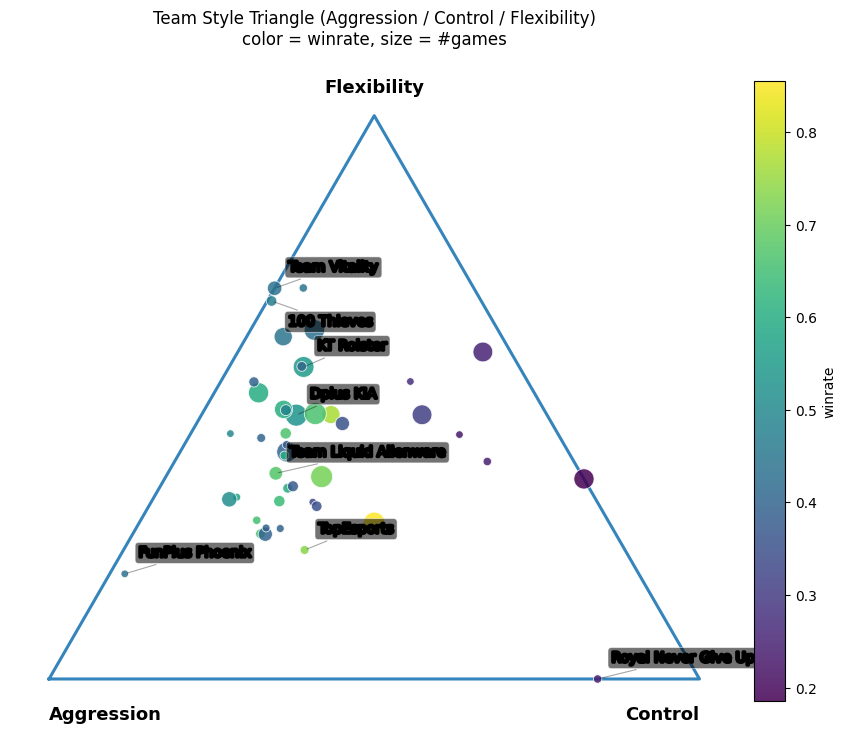

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# ---- build plot_df aligned with your x,y (same as before) ----
plot_df = style.loc[tri.index].copy()
plot_df["x"] = x
plot_df["y"] = y

# size scaling
ng = plot_df["n_games"].fillna(1).to_numpy()
ng = np.clip(ng, np.percentile(ng, 10), np.percentile(ng, 95))
sizes = 30 + 220 * (ng - ng.min()) / (ng.max() - ng.min() + 1e-9)

# ---- helpers ----
def draw_triangle(ax, lw=2.2, alpha=0.9):
    V = np.array([[0,0],[1,0],[0.5,np.sqrt(3)/2],[0,0]])
    ax.plot(V[:,0], V[:,1], lw=lw, alpha=alpha)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-0.06, 1.06)
    ax.set_ylim(-0.06, np.sqrt(3)/2 + 0.08)
    ax.axis("off")

def label_vertices(ax):
    ax.text(0.00, -0.04, "Aggression", ha="left", va="top", fontsize=13, fontweight="bold")
    ax.text(1.00, -0.04, "Control", ha="right", va="top", fontsize=13, fontweight="bold")
    ax.text(0.50, np.sqrt(3)/2 + 0.03, "Flexibility", ha="center", va="bottom", fontsize=13, fontweight="bold")

def _overlaps(a, b, pad=2):
    # a,b are (x0,y0,x1,y1) in display coords
    return not (a[2] < b[0]-pad or a[0] > b[2]+pad or a[3] < b[1]-pad or a[1] > b[3]+pad)

def place_labels(ax, df, max_labels=10):
    # pick informative labels: extreme style + high winrate + many games
    center = np.array([0.5, np.sqrt(3)/6])
    pts = df[["x","y"]].to_numpy()
    df = df.copy()
    df["_dist"] = np.linalg.norm(pts - center, axis=1)

    candidates = df[
        (df["winrate"] >= df["winrate"].quantile(0.90)) |
        (df["n_games"] >= df["n_games"].quantile(0.90)) |
        (df["_dist"] >= df["_dist"].quantile(0.92))
    ].copy()

    candidates = candidates.sort_values(["_dist","winrate","n_games"], ascending=False).head(max_labels)

    # offsets to try (in display pixels)
    offsets = [(10, 10), (12, -10), (-12, 10), (-12, -10), (18, 0), (-18, 0), (0, 18), (0, -18)]

    # we need a renderer for text extents
    fig = ax.figure
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    occupied = []
    for team, r in candidates.iterrows():
        px, py = ax.transData.transform((r["x"], r["y"]))  # point in display coords

        best = None
        for dx, dy in offsets:
            # create text (temporarily) to measure bbox
            t = ax.text(
                r["x"], r["y"], str(team),
                fontsize=10, ha="left", va="center",
                bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.55, edgecolor="white", linewidth=0.6),
                zorder=5
            )
            t.set_path_effects([pe.Normal()])

            # move in display coords by using annotation with offset points
            t.remove()
            ann = ax.annotate(
                str(team),
                xy=(r["x"], r["y"]), xycoords="data",
                xytext=(dx, dy), textcoords="offset points",
                ha="left" if dx >= 0 else "right",
                va="bottom" if dy >= 0 else "top",
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.55, edgecolor="white", linewidth=0.6),
                arrowprops=dict(arrowstyle="-", alpha=0.35, linewidth=0.8),
                zorder=6
            )
            ann.set_path_effects([pe.Stroke(linewidth=2.5, foreground="black"), pe.Normal()])

            fig.canvas.draw()
            bb = ann.get_window_extent(renderer=renderer)
            rect = (bb.x0, bb.y0, bb.x1, bb.y1)

            if not any(_overlaps(rect, o) for o in occupied):
                best = (ann, rect)
                break
            else:
                ann.remove()

        if best is None:
            # if we couldn't place it cleanly, just skip it (better than unreadable clutter)
            continue

        occupied.append(best[1])

# ---- plot ----
fig, ax = plt.subplots(figsize=(10, 9))
draw_triangle(ax)
label_vertices(ax)

sc = ax.scatter(
    plot_df["x"], plot_df["y"],
    c=plot_df["winrate"],
    s=sizes,
    cmap="viridis",
    alpha=0.85,
    edgecolors="white",
    linewidths=0.6,
    zorder=3
)

cbar = plt.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label("winrate")

ax.set_title("Team Style Triangle (Aggression / Control / Flexibility)\ncolor = winrate, size = #games", pad=14)

# label only a few, with collision avoidance
place_labels(ax, plot_df, max_labels=9)

plt.show()
